In [1]:
!pip install pandas matplotlib seaborn scikit-learn

**Task 3: Customer Segmentation / Clustering**

In [57]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv('/kaggle/input/ecommerce-transactions-dataset/Customers.csv')
transactions_df = pd.read_csv('/kaggle/input/ecommerce-transactions-dataset/Transactions.csv')

# Check the first few rows to understand the structure
print(customers_df.head())
print(transactions_df.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [58]:
# Merge Customers and Transactions on 'CustomerID'
data = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')

# Check the merged dataset
print(data.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


In [59]:
# Create TotalSpending: Total spending by each customer
customer_spending = data.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spending.columns = ['CustomerID', 'TotalSpending']

# Create NumTransactions: Number of transactions for each customer
customer_transactions = data.groupby('CustomerID')['TransactionID'].nunique().reset_index()
customer_transactions.columns = ['CustomerID', 'NumTransactions']

# Create AvgTransactionValue: Average transaction value for each customer
avg_transaction_value = data.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.columns = ['CustomerID', 'AvgTransactionValue']

# Merge the features into one dataframe
customer_features = pd.merge(customers_df[['CustomerID', 'Region']], customer_spending, on='CustomerID', how='left')
customer_features = pd.merge(customer_features, customer_transactions, on='CustomerID', how='left')
customer_features = pd.merge(customer_features, avg_transaction_value, on='CustomerID', how='left')

# Check the resulting features
print(customer_features.head())


  CustomerID         Region  TotalSpending  NumTransactions  \
0      C0001  South America        3354.52              5.0   
1      C0002           Asia        1862.74              4.0   
2      C0003  South America        2725.38              4.0   
3      C0004  South America        5354.88              8.0   
4      C0005           Asia        2034.24              3.0   

   AvgTransactionValue  
0              670.904  
1              465.685  
2              681.345  
3              669.360  
4              678.080  


In [60]:
from sklearn.preprocessing import StandardScaler

# Standardize the features: TotalSpending, NumTransactions, AvgTransactionValue
scaler = StandardScaler()
customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']] = scaler.fit_transform(
    customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']])

# Check the standardized data
print(customer_features.head())


  CustomerID         Region  TotalSpending  NumTransactions  \
0      C0001  South America      -0.061701        -0.011458   
1      C0002           Asia      -0.877744        -0.467494   
2      C0003  South America      -0.405857        -0.467494   
3      C0004  South America       1.032547         1.356650   
4      C0005           Asia      -0.783929        -0.923530   

   AvgTransactionValue  
0            -0.070263  
1            -0.934933  
2            -0.026271  
3            -0.076769  
4            -0.040028  


In [62]:
# Check for missing values in the selected columns
print(customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']].isna().sum())


TotalSpending          1
NumTransactions        1
AvgTransactionValue    1
dtype: int64


In [63]:
# Impute missing values with the column mean
customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']] = customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']].fillna(customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']].mean())


In [64]:
# Drop rows with NaN values
customer_features = customer_features.dropna(subset=['TotalSpending', 'NumTransactions', 'AvgTransactionValue'])


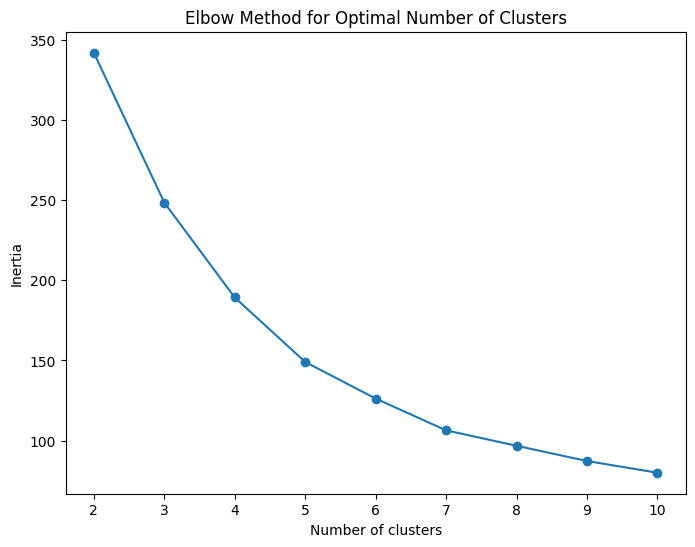

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Handle missing values by imputing with mean (Option 1)
customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']] = customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']].fillna(customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']].mean())

# Using the Elbow Method to determine the optimal number of clusters
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Explicitly set n_init
    kmeans.fit(customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Save the plot to /kaggle/working/
plt.savefig('/kaggle/working/elbow_plot.png')

# Optionally, save the inertia data to a CSV file
inertia_df = pd.DataFrame({'Clusters': range(2, 11), 'Inertia': inertia})
inertia_df.to_csv('/kaggle/working/inertia_data.csv', index=False)

# Show the plot
plt.show()


In [68]:
# Fit KMeans with 4 clusters (based on the elbow plot)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  # Setting n_init explicitly
customer_features['Cluster'] = kmeans.fit_predict(customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']])

# Check the resulting clusters
print(customer_features[['CustomerID', 'Cluster']].head())


  CustomerID  Cluster
0      C0001        0
1      C0002        3
2      C0003        0
3      C0004        2
4      C0005        3


In [70]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Davies-Bouldin Index
db_index = davies_bouldin_score(customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']], customer_features['Cluster'])

# Silhouette Score
sil_score = silhouette_score(customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']], customer_features['Cluster'])

# Output the metrics
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")


DB Index: 0.9079682574597397
Silhouette Score: 0.34628698846247147


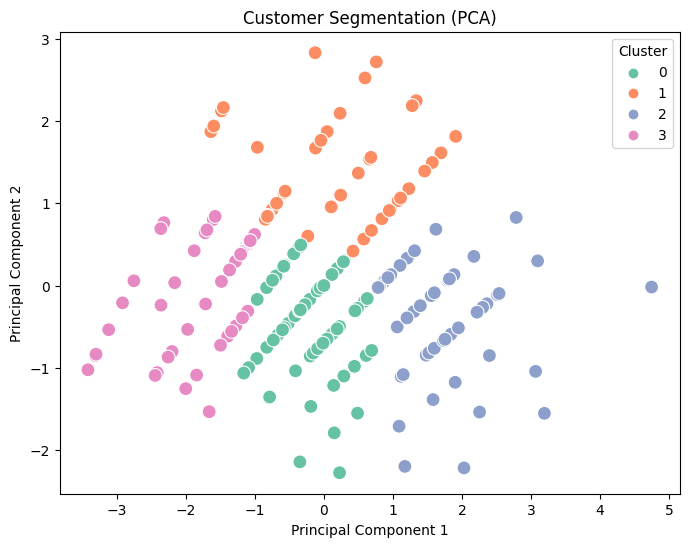

In [71]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']])

# Create a DataFrame with the PCA components and the clusters
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_features['Cluster']

# Plot the clusters in 2D
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=100)
plt.title('Customer Segmentation (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()
